In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import glob
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
import joblib

In [18]:
file_path_pattern = '/kaggle/input/drone-data-capstone/2024*.csv'

# Use glob to get a list of all file paths that match the pattern
file_list = glob.glob(file_path_pattern)

# Read each file and store it in a list
df_list = [pd.read_csv(file) for file in file_list]

# Concatenate all dataframes in the list into a single dataframe
df = pd.concat(df_list, ignore_index=True)

# Preview the merged data
print(df.head(), df.shape)

           timestamp airspeed armed attitude.pitch attitude.roll attitude.yaw  \
0  1731000945.334082      0.0  True      -0.086888     -0.018206     3.088753   
1   1731000945.84687      0.0  True      -0.087257     -0.018038     3.088943   
2  1731000946.353831      0.0  True      -0.087748     -0.018018      3.08935   
3  1731000946.861242      0.0  True      -0.087287     -0.017594     3.089216   
4  1731000947.367843      0.0  True      -0.087192     -0.017539     3.088813   

  battery.current battery.level battery.voltage commands.count  ...  \
0            0.31            63          15.276              0  ...   
1            0.31            63          15.276              0  ...   
2            0.31            63          15.276              0  ...   
3            0.27            64          15.317              0  ...   
4            0.27            64          15.317              0  ...   

  velocity[1] velocity[2] version.autopilot_type version.major version.minor  \
0     

In [19]:
df.columns

Index(['timestamp', 'airspeed', 'armed', 'attitude.pitch', 'attitude.roll',
       'attitude.yaw', 'battery.current', 'battery.level', 'battery.voltage',
       'commands.count', 'commands.next', 'ekf_ok', 'gimbal.pitch',
       'gimbal.roll', 'gimbal.yaw', 'gps_0.eph', 'gps_0.epv', 'gps_0.fix_type',
       'gps_0.satellites_visible', 'groundspeed', 'heading',
       'home_location.alt', 'home_location.global_frame', 'home_location.lat',
       'home_location.local_frame', 'home_location.lon', 'is_armable',
       'last_heartbeat', 'location.global_frame.alt',
       'location.global_frame.global_frame', 'location.global_frame.lat',
       'location.global_frame.local_frame', 'location.global_frame.lon',
       'location.global_relative_frame.alt',
       'location.global_relative_frame.global_frame',
       'location.global_relative_frame.lat',
       'location.global_relative_frame.local_frame',
       'location.global_relative_frame.lon', 'location.local_frame.down',
       'locatio

In [20]:
# data.replace([float('inf'), float('-inf')], float('nan'), inplace=True)
# data.dropna(inplace=True)
# data.isnull().sum()


# Feature Extraction
features = [ 'timestamp', 'gps_0.eph', 'gps_0.epv', 'gps_0.fix_type',
            'gps_0.satellites_visible', 'location.global_frame.lat',
            'location.global_frame.lon', 'location.global_frame.alt',
            'heading' ]

# Select all columns except those in columns_to_exclude
df = df[features].copy()

print(df.isnull().sum())
print(df.shape)

timestamp                    0
gps_0.eph                    0
gps_0.epv                    0
gps_0.fix_type               0
gps_0.satellites_visible     0
location.global_frame.lat    0
location.global_frame.lon    0
location.global_frame.alt    0
heading                      0
dtype: int64
(224, 9)


In [21]:
# Convert necessary columns to numeric values to avoid type errors
df['location.global_frame.lat'] = pd.to_numeric(df['location.global_frame.lat'], errors='coerce')
df['location.global_frame.lon'] = pd.to_numeric(df['location.global_frame.lon'], errors='coerce')
df['location.global_frame.alt'] = pd.to_numeric(df['location.global_frame.alt'], errors='coerce')
df['heading'] = pd.to_numeric(df['heading'], errors='coerce')
df['gps_0.eph'] = pd.to_numeric(df['gps_0.eph'], errors='coerce')
df['gps_0.epv'] = pd.to_numeric(df['gps_0.epv'], errors='coerce')
df['gps_0.satellites_visible'] = pd.to_numeric(df['gps_0.satellites_visible'], errors='coerce')

In [22]:
# Fill NaN values which might have been created during conversion to numeric
df.fillna(0, inplace=True)

In [23]:
# Feature Engineering
# Calculate deltas for latitude, longitude, and altitude
df['delta_lat'] = df['location.global_frame.lat'].diff().fillna(0)
df['delta_lon'] = df['location.global_frame.lon'].diff().fillna(0)
df['delta_alt'] = df['location.global_frame.alt'].diff().fillna(0)

In [24]:
# Calculate Euclidean distance between successive GPS points
df['distance'] = np.sqrt(df['delta_lat']**2 + df['delta_lon']**2 + df['delta_alt']**2)

In [25]:
# Data normalization
# if 'gps_0.fix_type' in df.columns:
#     # Handle categorical data by encoding 'gps_0.fix_type' as numerical
#     df = pd.get_dummies(df, columns=['gps_0.fix_type'])
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df.drop(columns=['timestamp', 'gps_0.fix_type']))
# Save the scaler
scaler_file = "scaler.pkl"
joblib.dump(scaler, scaler_file)

['scaler.pkl']

In [26]:
# Split the data into training and testing sets
X_train, X_test = train_test_split(df_scaled, test_size=0.2, random_state=42)
# Train One-Class SVM
clf = OneClassSVM(gamma='auto').fit(df_scaled)

In [ ]:
# # Custom scoring function
# def custom_scorer(estimator, X, y=None):
#     predictions = estimator.predict(X)
#     # Score can be defined as the fraction of correctly predicted samples
#     score = np.mean(predictions == 1)
#     return score

# # Create a dummy y array since One-Class SVM is unsupervised
# dummy_y = np.ones(len(X_test))
# # Evaluate feature importance using permutation importance
# results = permutation_importance(clf, X_test, dummy_y, n_repeats=10, random_state=42, n_jobs=2, scoring=custom_scorer)
# importance = results.importances_mean
# # Get feature names
# feature_names = enc_df.columns
# # Combine feature names with their importance scores
# feature_importance = pd.DataFrame({'feature': feature_names, 'importance': importance})
# # Sort features by importance
# feature_importance = feature_importance.sort_values(by='importance', ascending=False)
# print(feature_importance.head(10)) # Display top 10 important features

In [ ]:
# for i in feature_importance.values:
#     if i[1] > 0: 
#         print(i)
#     # print(feature_importance)

In [27]:
# Predict using the same data (for demonstration purposes; usually you'd want to test on new data)
predictions = clf.predict(df_scaled)
df['anomaly'] = predictions
df.to_csv('drone_data_with_anomalies.csv', index=False)

Prediction counts in the test data:
-1    113
 1    111
Name: count, dtype: int64


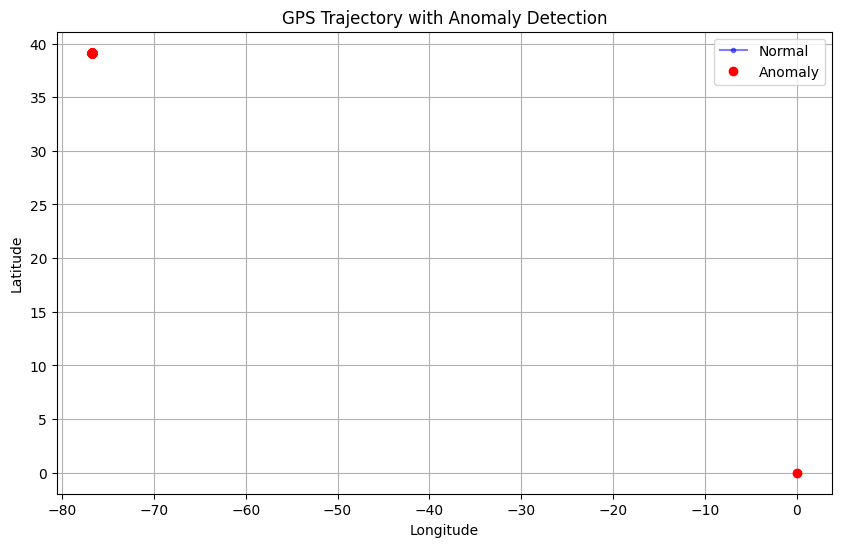

In [28]:
# Evaluate the model
print("Prediction counts in the test data:")
print(pd.Series(predictions).value_counts())

df = pd.read_csv('drone_data_with_anomalies.csv')
# Plot GPS trajectory with anomalies highlighted
plt.figure(figsize=(10, 6))
# Normal points
plt.plot(df.loc[df['anomaly'] == 1, 'location.global_frame.lon'],
         df.loc[df['anomaly'] == 1, 'location.global_frame.lat'],
         'b.-', label='Normal', alpha=0.5)
# Anomalous points
plt.plot(df.loc[df['anomaly'] == -1, 'location.global_frame.lon'],
         df.loc[df['anomaly'] == -1, 'location.global_frame.lat'],
         'ro', label='Anomaly')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('GPS Trajectory with Anomaly Detection')
plt.legend()
plt.grid()
plt.show()

----1----
----2----
----3----


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


----4----
----7----
----8----


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


----9----


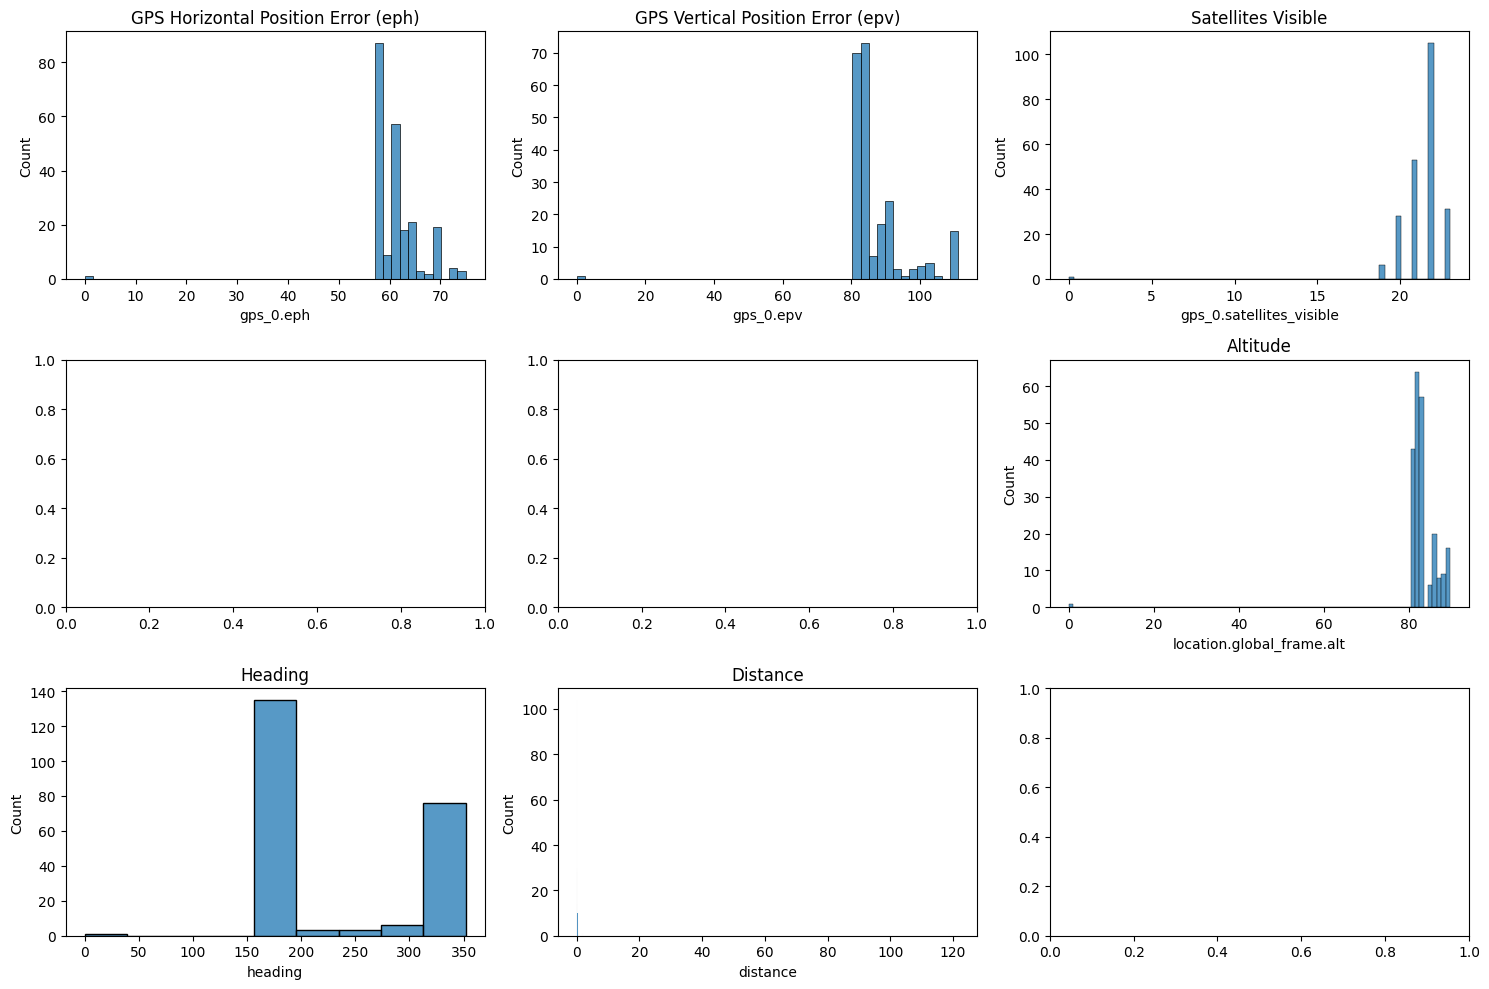

In [29]:
# Assuming we have dataframe with anomalies already calculated
df = pd.read_csv('drone_data_with_anomalies.csv')

# Replace inf values with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with NaN values (optional based on your data handling preference)
df.dropna(inplace=True)

# Plot the distributions of the key features
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
print("----1----")
sns.histplot(df['gps_0.eph'], ax=axes[0, 0])
axes[0, 0].set_title('GPS Horizontal Position Error (eph)')
print("----2----")

sns.histplot(df['gps_0.epv'], ax=axes[0, 1])
axes[0, 1].set_title('GPS Vertical Position Error (epv)')
print("----3----")

sns.histplot(df['gps_0.satellites_visible'], ax=axes[0, 2])
axes[0, 2].set_title('Satellites Visible')
print("----4----")

# sns.histplot(df['location.global_frame.lat'], ax=axes[1, 0])
# axes[1, 0].set_title('Latitude')
# print("----5----")

# sns.histplot(df['location.global_frame.lon'], ax=axes[1, 1])
# axes[1, 1].set_title('Longitude')
# print("----6----")

sns.histplot(df['location.global_frame.alt'], ax=axes[1, 2])
axes[1, 2].set_title('Altitude')
print("----7----")

sns.histplot(df['heading'], ax=axes[2, 0])
axes[2, 0].set_title('Heading')
print("----8----")

sns.histplot(df['distance'], ax=axes[2, 1])
axes[2, 1].set_title('Distance')
print("----9----")

plt.tight_layout()
plt.show()

In [30]:
print(df['location.global_frame.lat'])

0      39.142397
1      39.142397
2      39.142397
3      39.142397
4      39.142397
         ...    
219    39.142385
220    39.142386
221    39.142386
222    39.142386
223    39.142386
Name: location.global_frame.lat, Length: 224, dtype: float64


In [31]:
# Save the model to a file
joblib_file = "one_class_svm_model.pkl"
joblib.dump(clf, joblib_file)

print(f"Model saved to {joblib_file}")

Model saved to one_class_svm_model.pkl
